Geometry: NDBR50, Epoch [100/1000], Loss: 353574.3438
Geometry: NDBR50, Epoch [200/1000], Loss: 301074.0938
Geometry: NDBR50, Epoch [300/1000], Loss: 253536.0156
Geometry: NDBR50, Epoch [400/1000], Loss: 206195.9844
Geometry: NDBR50, Epoch [500/1000], Loss: 174549.0000
Geometry: NDBR50, Epoch [600/1000], Loss: 158198.0625
Geometry: NDBR50, Epoch [700/1000], Loss: 151960.5781
Geometry: NDBR50, Epoch [800/1000], Loss: 150239.5000
Geometry: NDBR50, Epoch [900/1000], Loss: 149881.6094
Geometry: NDBR50, Epoch [1000/1000], Loss: 149823.9844
Geometry: NDBR20, Epoch [100/1000], Loss: 148883.5938
Geometry: NDBR20, Epoch [200/1000], Loss: 148881.7656
Geometry: NDBR20, Epoch [300/1000], Loss: 148881.3750
Geometry: NDBR20, Epoch [400/1000], Loss: 148881.0781
Geometry: NDBR20, Epoch [500/1000], Loss: 148880.7812
Geometry: NDBR20, Epoch [600/1000], Loss: 148880.4531
Geometry: NDBR20, Epoch [700/1000], Loss: 148880.1406
Geometry: NDBR20, Epoch [800/1000], Loss: 148879.8125
Geometry: NDBR20, Epoch [90

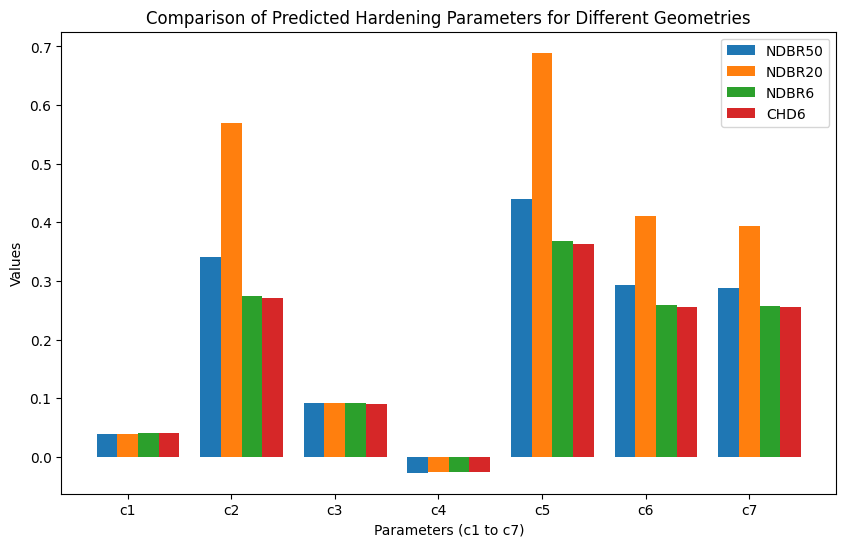

In [7]:
################################
##                            ##
##      leaky relu            ##
##                            ##
################################


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F


# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
dataPoints = {'NDBR50': 50000, 'NDBR20': 50000, 'NDBR6': 50000, 'CHD6': 50000}

# Load data from CSV files
X_files = {
    'NDBR50': "MODEL_DATA/NEWDATA/newData_NDBR50_FD.csv",
    'NDBR20': "MODEL_DATA/NEWDATA/newData_NDBR20_FD.csv",
    'NDBR6': "MODEL_DATA/NEWDATA/newData_NDBR6_FD.csv",
    'CHD6': "MODEL_DATA/NEWDATA/newData_CHD6_FD.csv"
}

Y_file = "MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv"

X_data = {geometry: pd.read_csv(X_files[geometry], usecols=[0, 1]).values for geometry in geometries}
Y_data = pd.read_csv(Y_file).values

# Define a custom neural network model with regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.bn4 = nn.BatchNorm1d(hidden_size4)
        self.relu4 = nn.LeakyReLU(negative_slope=0.01)
        self.fc5 = nn.Linear(hidden_size4, output_size)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu1(x)
        x = self.fc2(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu2(x)
        x = self.fc3(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu3(x)
        x = self.fc4(x)
        x = F.relu(x)  # Apply ReLU activation with threshold 0
        x = self.relu4(x)
        x = self.fc5(x)
        return x


class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        reg_loss = torch.mean((outputs - target_values) ** 2)
        return mse_loss + self.lambda_reg * reg_loss

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 128  # Number of units in the first hidden layer
hidden_size2 = 128  # Number of units in the second hidden layer
hidden_size3 = 64  # Number of units in the second hidden layer
hidden_size4 = 64  # Number of units in the second hidden layer
output_size = 7    # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)


# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = CustomMSELoss(lambda_reg=0.001)  # Adjust lambda_reg as needed
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 1000

target_values = torch.tensor([ 0.5, 1300, 0.000000000000023, 0.075, 773.18, 1039.37, 73.94], 
                             dtype=torch.float32)

for geometry in geometries:
    num_samples = min(dataPoints[geometry], len(Y_data))
    X_sample = torch.tensor(X_data[geometry][:num_samples], dtype=torch.float32)
    Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Compute the loss with regularization
        loss = criterion(outputs, Y_sample, target_values)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Geometry: {geometry}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Predict parameters for all geometries
predicted_parameters = {}

for geometry in geometries:
    X_test = torch.tensor(X_data[geometry][:1], dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_test)

    predicted_parameters[geometry] = predictions[0].tolist()

# Print predicted parameters for all geometries
for geometry, params in predicted_parameters.items():
    print(f'Predicted parameters for geometry {geometry}:')
    print(params)

# Visualize 'c1' to 'c7' values for each geometry in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = [predicted_parameters[geometry] for geometry in geometries]

plt.figure(figsize=(10, 6))
for i, geometry in enumerate(geometries):
    plt.bar(np.arange(len(param_names)) + i * 0.2, param_values[i], width=0.2, label=f'{geometry}')

plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Comparison of Predicted Hardening Parameters for Different Geometries')
plt.xticks(np.arange(len(param_names)) + 0.2, param_names)

plt.legend()
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

# Define the geometries and yielding indices
geometries = ['NDBR50', 'NDBR20', 'NDBR6', 'CHD6']
dataPoints = {'NDBR50': 50000, 'NDBR20': 50000, 'NDBR6': 50000, 'CHD6': 50000}

# Load data from CSV files for all geometries
X_files = {
    geometry: f"MODEL_DATA/NEWDATA/newData_{geometry}_FD.csv" for geometry in geometries
}

# Combine data from all geometries
X_data_combined = []
Y_data_combined = []

for geometry in geometries:
    num_samples = min(dataPoints[geometry], len(Y_data))
    X_data_combined.append(pd.read_csv(X_files[geometry], usecols=[0, 1]).values[:num_samples])
    Y_data_combined.append(Y_data[:num_samples])

X_data_combined = np.vstack(X_data_combined)
Y_data_combined = np.vstack(Y_data_combined)

input_size = 2  # Number of input parameters (force and displacement)
hidden_size1 = 64  # Number of units in the first hidden layer
hidden_size2 = 64  # Number of units in the second hidden layer
hidden_size3 = 64  # Number of units in the third hidden layer
hidden_size4 = 64  # Number of units in the fourth hidden layer
output_size = 7  # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size)

# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = CustomMSELoss(lambda_reg=0.1)  # Adjust lambda_reg as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

# Target values for all geometries
target_values = torch.tensor([0.5, 1300, 2.3 * 10 ** -14, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

# Convert the combined data to tensors
X_sample = torch.tensor(X_data_combined, dtype=torch.float32)
Y_sample = torch.tensor(Y_data_combined, dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Compute the loss with regularization
    loss = criterion(outputs, Y_sample, target_values)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Predict parameters for any geometry
X_test = torch.tensor(X_data_combined[:1], dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters
print(f'Predicted parameters for all geometries:')
print(predictions[0].tolist())


Epoch [100/1000], Loss: 176571.7344
Epoch [200/1000], Loss: 176522.1562
Epoch [300/1000], Loss: 176471.0938
Epoch [400/1000], Loss: 176417.1562
Epoch [500/1000], Loss: 176359.0938
Epoch [600/1000], Loss: 176287.6406
Epoch [700/1000], Loss: 176258.1562
Epoch [800/1000], Loss: 176068.8438
Epoch [900/1000], Loss: 175906.0000
Epoch [1000/1000], Loss: 175298.1562
Predicted parameters for all geometries:
[5.225199222564697, 101.61713409423828, 1.4386926889419556, 0.16475889086723328, 151.19541931152344, 103.72527313232422, 81.92597961425781]


Epoch [100/1000], Loss: 167774.9688
Epoch [200/1000], Loss: 164998.9688
Epoch [300/1000], Loss: 163782.8281
Epoch [400/1000], Loss: 162894.7188
Epoch [500/1000], Loss: 161928.8438
Epoch [600/1000], Loss: 160879.8750
Epoch [700/1000], Loss: 159485.7031
Epoch [800/1000], Loss: 157579.3594
Epoch [900/1000], Loss: 155282.3281
Epoch [1000/1000], Loss: 153210.6094
Predicted parameters:
[0.322135865688324, 13.931447982788086, -1.3901373147964478, -1.39719557762146, 8.190875053405762, 5.5161261558532715, 4.597056865692139]


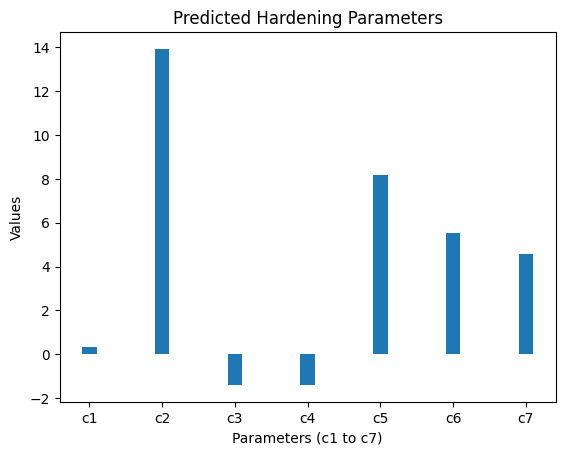

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Define a custom neural network model with regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu_out = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        reg_loss = torch.mean((outputs - target_values) ** 2)
        return mse_loss + self.lambda_reg * reg_loss

input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
hidden_size1 = 64
hidden_size2 = 64
output_size = 7  # Number of output dimensions (c1 to c7)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Define a loss function (custom MSE loss with regularization) and an optimizer (e.g., Adam)
criterion = CustomMSELoss(lambda_reg=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

target_values = torch.tensor([0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94],
                             dtype=torch.float32)

num_samples = len(Y_data)
X_sample = torch.tensor(X_data[:num_samples], dtype=torch.float32)
Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Compute the loss with regularization
    loss = criterion(outputs, Y_sample, target_values)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Predict parameters
X_test = torch.tensor(X_data[:1], dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()


Epoch [100/1000], Loss: 147769.2812
Epoch [200/1000], Loss: 145345.9531
Epoch [300/1000], Loss: 143691.5781
Epoch [400/1000], Loss: 141745.7812
Epoch [500/1000], Loss: 138702.1094
Epoch [600/1000], Loss: 135649.8750
Epoch [700/1000], Loss: 133508.4062
Epoch [800/1000], Loss: 130763.5391
Epoch [900/1000], Loss: 127671.6250
Epoch [1000/1000], Loss: 124679.0078
Predicted parameters:
[0.019310541450977325, 3.956756591796875, 0.26016950607299805, -0.11449022591114044, 2.513576030731201, 1.489471673965454, 2.494490146636963]


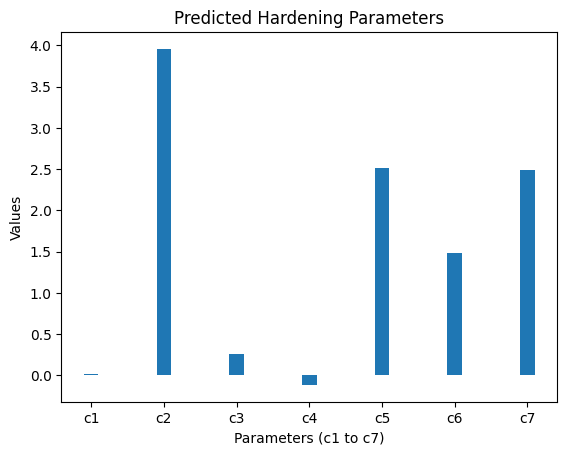

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Define a custom neural network model with L2 regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lambda_reg):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu_out = nn.ReLU()

        # Create a list of all the layers you want to apply L2 regularization to
        self.regularization_layers = [self.fc1, self.fc2, self.fc3]

        # Define the regularization strength (lambda)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def l2_regularization(self):
        # Calculate L2 regularization loss
        l2_reg = 0.0
        for layer in self.regularization_layers:
            l2_reg += torch.norm(layer.weight)
        return self.lambda_reg * l2_reg

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        return mse_loss + self.lambda_reg * target_values

input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
hidden_size1 = 64
hidden_size2 = 64
output_size = 7  # Number of output dimensions (c1 to c7)

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, lambda_reg)

# Define a loss function (custom MSE loss with L2 regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001

target_values = torch.tensor([0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94],
                             dtype=torch.float32)

num_samples = len(Y_data)
X_sample = torch.tensor(X_data[:num_samples], dtype=torch.float32)
Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Compute the MSE loss
    mse_loss = criterion(outputs, Y_sample)

    # Calculate L2 regularization separately
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)

    # Combine the MSE loss and L2 regularization
    loss = mse_loss + lambda_reg * l2_reg

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Predict parameters
X_test = torch.tensor(X_data[:1], dtype=torch.float32)
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()


In [16]:
# Perform Min-Max scaling on input data and target values
from sklearn.preprocessing import MinMaxScaler

# Scale the input data
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

# Scale the target values
target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)
inverse_predictions = target_scaler.inverse_transform(predictions)
inverse_predictions


array([[ 2.19490116e-02,  7.70084977e+03,  2.62002910e-02,
        -1.06956019e-01,  4.99857543e+03,  1.48193830e+03,
         2.47583346e+03]])

Epoch [100/5000], Loss: 0.0912
Epoch [200/5000], Loss: 0.0892
Epoch [300/5000], Loss: 0.0882
Epoch [400/5000], Loss: 0.0874
Epoch [500/5000], Loss: 0.0868
Epoch [600/5000], Loss: 0.0860
Epoch [700/5000], Loss: 0.0852
Epoch [800/5000], Loss: 0.0846
Epoch [900/5000], Loss: 0.0842
Epoch [1000/5000], Loss: 0.0839
Epoch [1100/5000], Loss: 0.0837
Epoch [1200/5000], Loss: 0.0834
Epoch [1300/5000], Loss: 0.0833
Epoch [1400/5000], Loss: 0.0831
Epoch [1500/5000], Loss: 0.0830
Epoch [1600/5000], Loss: 0.0829
Epoch [1700/5000], Loss: 0.0828
Epoch [1800/5000], Loss: 0.0827
Epoch [1900/5000], Loss: 0.0826
Epoch [2000/5000], Loss: 0.0826
Epoch [2100/5000], Loss: 0.0825
Epoch [2200/5000], Loss: 0.0825
Epoch [2300/5000], Loss: 0.0824
Epoch [2400/5000], Loss: 0.0824
Epoch [2500/5000], Loss: 0.0824
Epoch [2600/5000], Loss: 0.0823
Epoch [2700/5000], Loss: 0.0823
Epoch [2800/5000], Loss: 0.0823
Epoch [2900/5000], Loss: 0.0823
Epoch [3000/5000], Loss: 0.0823
Epoch [3100/5000], Loss: 0.0823
Epoch [3200/5000]

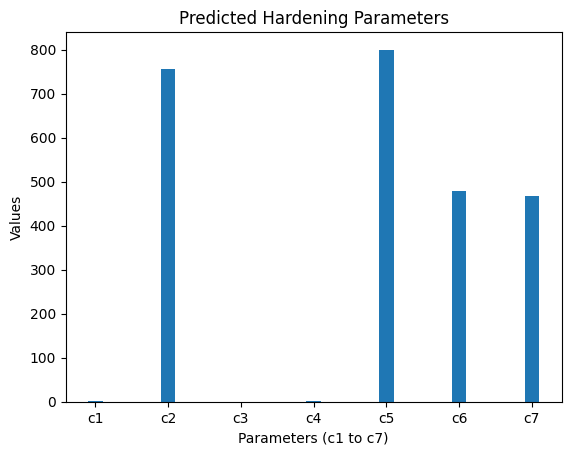

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.helper import SliceDict

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Define a custom neural network model with L2 regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lambda_reg):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu_out = nn.ReLU()

        # Create a list of all the layers you want to apply L2 regularization to
        self.regularization_layers = [self.fc1, self.fc2, self.fc3]

        # Define the regularization strength (lambda)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def l2_regularization(self):
        # Calculate L2 regularization loss
        l2_reg = 0.0
        for layer in self.regularization_layers:
            l2_reg += torch.norm(layer.weight)
        return self.lambda_reg * l2_reg

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        return mse_loss + self.lambda_reg * target_values

input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
hidden_size1 = 64
hidden_size2 = 64
output_size = 7  # Number of output dimensions (c1 to c7)

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001

# Create Min-Max scalers for input data and target values
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, lambda_reg)

# Define a loss function (custom MSE loss with L2 regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(torch.tensor(X_data_scaled, dtype=torch.float32))

    # Inverse scale the predictions to the original range
    predictions = target_scaler.inverse_transform(outputs.detach().numpy())

    # Compute the MSE loss
    mse_loss = criterion(outputs, torch.tensor(Y_data_scaled, dtype=torch.float32))

    # Calculate L2 regularization separately
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)

    # Combine the MSE loss and L2 regularization
    loss = mse_loss + lambda_reg * l2_reg

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Predict parameters
X_test_scaled = input_scaler.transform(X_data[:1])
with torch.no_grad():
    predictions = model(torch.tensor(X_test_scaled, dtype=torch.float32))

# Inverse scale the predictions to the original range
predictions = target_scaler.inverse_transform(predictions.detach().numpy())

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = []
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.layers = nn.ModuleList(self.layers)
        
        # Create a list of all the layers you want to apply L2 regularization to
        self.regularization_layers = self.layers

        # Define the regularization strength (lambda)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for i, layer in enumerate(self.layers):
            if i == layer_index_for_c6:
                # Apply heavier regularization for c6
                l2_reg += self.lambda_reg_c6 * torch.norm(layer.weight)
            elif i == layer_index_for_c7:
                # Apply heavier regularization for c7
                l2_reg += self.lambda_reg_c7 * torch.norm(layer.weight)
            else:
                # Apply regular regularization for other layers
                l2_reg += self.lambda_reg * torch.norm(layer.weight)
        return l2_reg

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001
lambda_reg_c6 = 0.01  
lambda_reg_c7 = 0.01

hidden_sizes = [128, 64, 32]  # Three hidden layers with 128, 64, and 32 neurons, respectively
input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
output_size = 7  # Number of output dimensions (c1 to c7)

# Custom loss function with regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0, weight_c6=10.0, weight_c7=10.0):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.weight_c6 = weight_c6
        self.weight_c7 = weight_c7

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)
        # Weight the loss for c6 and c7
        weighted_mse_loss[5] *= self.weight_c6
        weighted_mse_loss[6] *= self.weight_c7

        # Calculate L2 regularization
        reg_loss = torch.mean(outputs ** 2)

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

model = ComplexNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, lambda_reg)

# Define a loss function (custom MSE loss with L2 regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Training loop
num_epochs = 1000

target_values = torch.tensor([0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94],
                             dtype=torch.float32)

num_samples = len(Y_data)
X_sample = torch.tensor(X_data[:num_samples], dtype=torch.float32)
Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Calculate the MSE loss
    mse_loss = criterion(outputs, Y_sample)

    # Calculate L2 regularization separately
    l2_reg = model.l2_regularization()

    # Combine the MSE loss and L2 regularization
    loss = mse_loss + lambda_reg * l2_reg

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()


TypeError: ComplexNeuralNetwork.__init__() takes 5 positional arguments but 6 were given

Epoch [100/1000], Loss: 438441.0000
Epoch [200/1000], Loss: 279402.6875
Epoch [300/1000], Loss: 147501.6719
Epoch [400/1000], Loss: 129882.0859
Epoch [500/1000], Loss: 126061.1484
Epoch [600/1000], Loss: 122826.2188
Epoch [700/1000], Loss: 119943.5859
Epoch [800/1000], Loss: 117484.5000
Epoch [900/1000], Loss: 115480.4375
Epoch [1000/1000], Loss: 113915.1875
Predicted parameters:
[-116.52597045898438, 4610.615234375, -1797.470458984375, 1898.108154296875, 3929.255859375, 2497.89599609375, 3544.5546875]


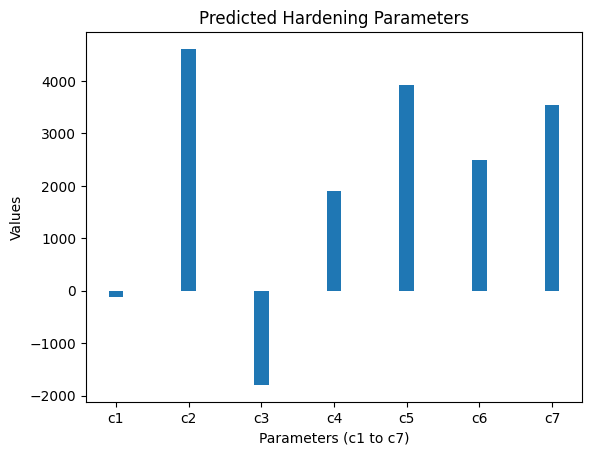

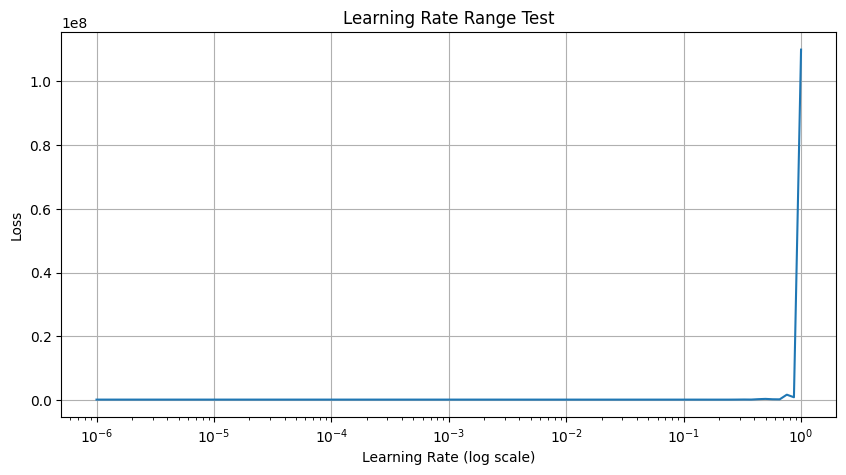

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lambda_reg):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu_out = nn.ReLU()

        # Create a list of all the layers you want to apply L2 regularization to
        self.regularization_layers = [self.fc1, self.fc2, self.fc3]

        # Define the regularization strength (lambda)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def l2_regularization(self):
        # Calculate L2 regularization loss
        l2_reg = 0.0
        for layer in self.regularization_layers:
            l2_reg += torch.norm(layer.weight)
        return self.lambda_reg * l2_reg

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets):
        mse_loss = nn.MSELoss()(outputs, targets)
        reg_loss = torch.mean(outputs ** 2)
        return mse_loss + self.lambda_reg * reg_loss

input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
hidden_size1 = 64
hidden_size2 = 64
output_size = 7  # Number of output dimensions (c1 to c7)

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001

learning_rate_min = 1e-6
learning_rate_max = 1
num_lr_steps = 100

learning_rates = []
losses = []

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, lambda_reg)

# Define a loss function (custom MSE loss with L2 regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

target_values = torch.tensor([0.5, 1300, 2.3 * 10**-14, 0.075, 773.18, 1039.37, 73.94],
                             dtype=torch.float32)

num_samples = len(Y_data)
X_sample = torch.tensor(X_data[:num_samples], dtype=torch.float32)
Y_sample = torch.tensor(Y_data[:num_samples], dtype=torch.float32)

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_sample)

    # Calculate the MSE loss
    mse_loss = criterion(outputs, Y_sample)

    # Calculate L2 regularization separately
    l2_reg = model.l2_regularization()

    # Combine the MSE loss and L2 regularization
    loss = mse_loss + lambda_reg * l2_reg

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

for lr_step in range(num_lr_steps):
    # Set a new learning rate for the optimizer
    lr = 10 ** (np.log10(learning_rate_min) + (np.log10(learning_rate_max) - np.log10(learning_rate_min)) * lr_step / (num_lr_steps - 1))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Training loop for a small number of epochs
    num_epochs = 10  # You can adjust this
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_sample)

        # Calculate the MSE loss
        mse_loss = criterion(outputs, Y_sample)

        # Calculate L2 regularization separately
        l2_reg = model.l2_regularization()

        # Combine the MSE loss and L2 regularization
        loss = mse_loss + lambda_reg * l2_reg

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store the learning rate and its corresponding loss
    learning_rates.append(lr)
    losses.append(loss.item())

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()

plt.figure(figsize=(10, 5))
plt.semilogx(learning_rates, losses)
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.grid()
plt.show()


In [44]:
optimal_lr = learning_rates[np.argmin(np.gradient(losses))]
print(f'Optimal Learning Rate: {optimal_lr}')

Optimal Learning Rate: 0.572236765935022


Epoch [100/1000], Loss: 2501307.0000, Validation Loss: 2619057.2500
Epoch [200/1000], Loss: 900639.0000, Validation Loss: 921718.8125
Epoch [300/1000], Loss: 836905.9375, Validation Loss: 836843.6875
Epoch [400/1000], Loss: 798203.3750, Validation Loss: 792182.2500
Epoch [500/1000], Loss: 779808.8750, Validation Loss: 769960.0000
Epoch [600/1000], Loss: 772380.8125, Validation Loss: 761102.9375
Epoch [700/1000], Loss: 768926.5625, Validation Loss: 757651.6250
Epoch [800/1000], Loss: 767236.3125, Validation Loss: 756394.8125
Epoch [900/1000], Loss: 766508.5000, Validation Loss: 756072.3750
Early stopping at epoch 964 as validation loss did not improve for 20 consecutive epochs.
Clipped Predicted parameters:
[0.3367938697338104, 1200.0, 0.0010000000474974513, 0.10000000149011612, 647.1726684570312, 1000.0, 100.0]


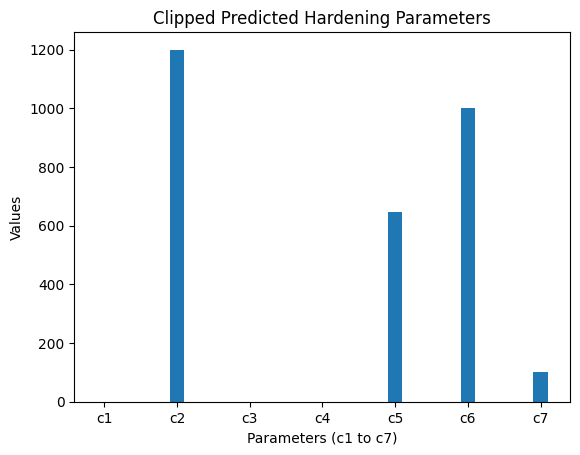

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"
combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Normalize the input data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define a custom neural network model with L2 regularization
class ComplexNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7):
        super(ComplexNeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(nn.LeakyReLU(negative_slope=0.01))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Define the regularization strengths
        self.lambda_reg = lambda_reg
        self.lambda_reg_c6 = lambda_reg_c6
        self.lambda_reg_c7 = lambda_reg_c7

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def l2_regularization(self):
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param) ** 2
        return l2_reg

# Define the L2 regularization strengths
lambda_reg = 0.0001
lambda_reg_c6 = 0.00001
lambda_reg_c7 = 0.00001

hidden_sizes = [128,64,32]
input_size = 8
output_size = 7

# Custom loss function with regularization and target parameter regularization
class CustomWeightedMSELoss(nn.Module):
    def __init__(self, lambda_reg=0.0, weight_c6=100.0, weight_c7=100.0, target_params=None):
        super(CustomWeightedMSELoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.weight_c6 = weight_c6
        self.weight_c7 = weight_c7
        self.target_params = target_params

    def forward(self, outputs, targets):
        errors = outputs - targets
        squared_errors = errors ** 2

        # Calculate the weighted MSE loss
        weighted_mse_loss = torch.mean(squared_errors, dim=0)
        # Weight the loss for c6 and c7
        weighted_mse_loss[5] *= self.weight_c6
        weighted_mse_loss[6] *= self.weight_c7

        # Calculate L2 regularization
        reg_loss = 0.0
        for param in self.parameters():
            reg_loss += torch.norm(param) ** 2

        # Add regularization term to make the predicted parameters closer to the target parameters
        if self.target_params is not None:
            target_diff = (outputs - self.target_params) ** 2
            reg_loss += torch.mean(target_diff)

        return torch.sum(weighted_mse_loss) + self.lambda_reg * reg_loss

# Target parameters
target_params = torch.tensor([0.5, 1300, 0.000000000023, 0.075, 773.18, 1039.37, 73.94], dtype=torch.float32)

# Create an instance of the neural network
model = ComplexNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg, lambda_reg_c6, lambda_reg_c7)

# Define a loss function (custom MSE loss with L2 regularization and target parameter regularization)
criterion = CustomWeightedMSELoss(lambda_reg=lambda_reg, weight_c6=1.0, weight_c7=1.0, target_params=target_params)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with default learning rate

# Split the data into training and validation sets
num_samples = len(Y_data)
split_ratio = 0.8  
split_index = int(split_ratio * num_samples)

X_train = torch.tensor(X_data[:split_index], dtype=torch.float32)
Y_train = torch.tensor(Y_data[:split_index], dtype=torch.float32)
X_val = torch.tensor(X_data[split_index:], dtype=torch.float32)
Y_val = torch.tensor(Y_data[split_index:], dtype=torch.float32)

# Define early stopping parameters
patience = 20  # Number of consecutive epochs without improvement to tolerate
best_val_loss = float('inf')
no_improvement_count = 0

# Training loop with early stopping
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)

    # Calculate the custom weighted MSE loss with regularization
    loss = criterion(outputs, Y_train)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation loss
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model when validation loss improves
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} consecutive epochs.')
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define the value ranges for each parameter
param_ranges = {
    'c1': (0.0, 1.0),
    'c2': (1200, 1500),
    'c3': (0.0, 0.001),
    'c4': (0.0, 0.1),
    'c5': (500, 1000),
    'c6': (1000, 1500),
    'c7': (0, 100)
}

# Normalize the input data for prediction
X_test = torch.tensor(scaler.transform(X_data[:1]), dtype=torch.float32)

# Predict parameters
with torch.no_grad():
    predictions = model(X_test)

param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
# Clip the predicted values to the specified ranges
for i, param_name in enumerate(param_names):
    min_val, max_val = param_ranges[param_name]
    predictions[0][i] = torch.clamp(predictions[0][i], min_val, max_val)

# Print the clipped predicted parameters
print(f'Clipped Predicted parameters:')
print(predictions[0].tolist())

# Visualize clipped 'c1' to 'c7' values in a single graph
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Clipped Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()